# EEG-Based Visual Recognition: Classification to Semantic Retrieval
## Final Project Submission - Group 10

**Team Members:** Madhavi Gulavani, Praneeth Chaitanya Jonnavithula, Prithiraj Bhuyan

**Course:** 11-685 Introduction to Deep Learning (Fall 2025)

---

This notebook implements:
1. **Task 1**: EEG-based image classification with advanced architectures
2. **Task 2A**: Image-Caption retrieval using pretrained CLIP
3. **Task 2B**: EEG-Caption retrieval with various CLIP fine-tuning strategies
4. **Comprehensive Evaluation**: All required metrics and analyses

## Setup and Imports

In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import wandb
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer
import torch.nn.functional as F

In [17]:
# Set Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

✅ Using device: cuda


In [18]:
# Login to WandB
wandb.login(key="825201e63a02e53435b53a136158ab39815c89a4")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gulavani/.netrc


True

## Data Loading and Preprocessing

In [19]:
BIDS_ROOT = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589'
IMAGE_DIR = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images'
CAPTIONS_FILE = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt'
ALL_SUBJECTS = ['sub-02', 'sub-03', 'sub-05', 'sub-09', 'sub-14', 'sub-15', 
                'sub-17', 'sub-19', 'sub-20', 'sub-23', 'sub-24', 'sub-28', 'sub-29']

class EEG_Paper_Replication_Dataset(Dataset):
    def __init__(self, bids_root, images_dir, captions_path, 
                 subject_list, session_list, 
                 clamp_thres=500, stats=None):
        
        self.bids_root = bids_root
        self.images_dir = images_dir
        self.clamp_thres = clamp_thres
        self.trial_metadata = []
        
        # --- Create Subject Mapping ---
        # Map 'sub-02' -> 0, 'sub-03' -> 1, etc.
        # We sort to ensure consistency across Train/Val/Test sets
        self.subject_to_idx = {sub: i for i, sub in enumerate(sorted(list(set(subject_list))))}
        
        # 1. Load Captions Helper
        self.captions_dict = self._load_captions(captions_path)
        self.category_to_idx = {cat: i for i, cat in enumerate(sorted(set(c for c, _ in self.captions_dict.values())))}
        
        # 2. Scan Metadata
        print(f"Scanning metadata for {session_list}...")
        for sub in subject_list:
            for ses in session_list:
                for run in ['01', '02', '03', '04']:
                    session_path = os.path.join(self.bids_root, sub, ses)
                    csv_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_image.csv")
                    npy_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_1000Hz.npy")
                    
                    if not (os.path.exists(csv_path) and os.path.exists(npy_path)):
                        continue
                        
                    try:
                        csv_data = pd.read_csv(csv_path)
                        for i, row in csv_data.iterrows():
                            img_base_name = self._get_base_name(row['FilePath'])
                            if not img_base_name: continue
                            
                            category, caption = self.captions_dict.get(img_base_name, (None, None))
                            if not category: continue
                            
                            self.trial_metadata.append({
                                'npy_path': npy_path,
                                'trial_index': i,
                                'label': self.category_to_idx[category],
                                'subject_id': self.subject_to_idx[sub],
                                'image_name': img_base_name,
                                'caption': caption 
                            })
                    except:
                        continue
        
        print(f"Found {len(self.trial_metadata)} trials.")

        # 3. Compute Global Statistics (GFS)
        if stats is None:
            print("Computing Global Statistics (this takes ~1 min)...")
            self.mean, self.std = self._compute_global_stats()
        else:
            self.mean, self.std = stats

    def _compute_global_stats(self):
        subset_indices = range(0, len(self.trial_metadata), 10)
        sum_x = 0
        sum_sq_x = 0
        count = 0
        
        for i in tqdm(subset_indices, desc="Calculating Stats"):
            meta = self.trial_metadata[i]
            d = np.load(meta['npy_path'])[meta['trial_index']]
            d = np.clip(d, -self.clamp_thres, self.clamp_thres)
            
            sum_x += np.mean(d)
            sum_sq_x += np.mean(d**2)
            count += 1
            
        global_mean = sum_x / count
        global_std = np.sqrt((sum_sq_x / count) - (global_mean**2))
        return float(global_mean), float(global_std)

    def get_stats(self): return self.mean, self.std

    def _load_captions(self, path):
        d = {}
        with open(path, 'r') as f:
            next(f)
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 4: d[parts[2]] = (parts[1], parts[3])
        return d

    def _get_base_name(self, p):
        try:
            bn = os.path.splitext(os.path.basename(str(p).replace('\\', '/')))[0]
            if bn.endswith('_resized'): return bn[:-8]
            return bn
        except: return None

    def _get_image_path(self, image_name):
        """Find full path to image file"""
        for ext in ['.jpg', '.jpeg', '.png', '.JPEG', '.JPG']:
            path = os.path.join(self.images_dir, image_name + ext)
            if os.path.exists(path):
                return path
        return None  # Image not found

    def __len__(self): return len(self.trial_metadata)

    def __getitem__(self, idx):
        meta = self.trial_metadata[idx]
        eeg_data = np.load(meta['npy_path'])[meta['trial_index']]
        eeg_data = np.clip(eeg_data, -self.clamp_thres, self.clamp_thres)
        # Global Feature Standardization
        eeg_data = (eeg_data - self.mean) / (self.std + 1e-6)

        img_path = self._get_image_path(meta['image_name'])
        caption = meta['caption']
        
        return {
            'eeg': torch.tensor(eeg_data, dtype=torch.float32),
            'label': torch.tensor(meta['label'], dtype=torch.long),
            'subject_id': torch.tensor(meta['subject_id'], dtype=torch.long),
            'image_path': img_path,  # for Task 2
            'caption': caption  # for Task 2
        }

In [20]:
# ============================================================================
# CREATE DATASETS AND DATALOADERS
# ============================================================================
# 1. Create Transforms (Standard ImageNet stats)
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Instantiate Training Dataset
print("--- Init Train ---")
train_ds = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT, 
    images_dir=IMAGE_DIR, 
    captions_path=CAPTIONS_FILE, 
    subject_list=ALL_SUBJECTS, 
    session_list=['ses-01', 'ses-02', 'ses-03'], 
    clamp_thres=500
)
# Save stats to use for validation (Prevent data leakage)
stats = train_ds.get_stats()

# 3. Instantiate Validation Dataset
print("\n--- Init Validation ---")
val_ds = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT, 
    images_dir=IMAGE_DIR, 
    captions_path=CAPTIONS_FILE, 
    subject_list=ALL_SUBJECTS, 
    session_list=['ses-04'], 
    clamp_thres=500,
    stats=stats # <--- IMPORTANT: Use training stats
)

print("Loading Test Set (Session 5)...")
test_ds = EEG_Paper_Replication_Dataset(
    BIDS_ROOT, IMAGE_DIR, CAPTIONS_FILE, ALL_SUBJECTS, 
    ['ses-05'], # FINAL TEST SET
    stats=stats,
    clamp_thres=500
)

# 4. Define The Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

print(f"\n✅ Loaders Ready: {len(train_loader)} training batches, {len(val_loader)} validation batches.")


--- Init Train ---
Scanning metadata for ['ses-01', 'ses-02', 'ses-03']...
Found 15600 trials.
Computing Global Statistics (this takes ~1 min)...


Calculating Stats:   0%|          | 0/1560 [00:00<?, ?it/s]


--- Init Validation ---
Scanning metadata for ['ses-04']...
Found 5200 trials.
Loading Test Set (Session 5)...
Scanning metadata for ['ses-05']...
Found 5200 trials.

✅ Loaders Ready: 488 training batches, 163 validation batches.


## Task 1: EEG Classification

### Model Architecture

We implement a multi-head architecture with:
1. **CNN Feature Extractor**: Extracts temporal features from EEG channels
2. **Transformer Backbone**: Models relationships across channels (shared across subjects)
3. **Subject-Specific Heads**: Separate classification heads for each subject

In [36]:
class EEG_ViT_1D(nn.Module):
    def __init__(self, num_subjects=13, num_classes=20):
        super().__init__()
        
        # --- Hyperparameters ---
        self.patch_size = 50      # 50ms window 
        self.stride = 25          # 50% overlap
        self.embed_dim = 128      # Feature size
        self.num_heads = 4
        self.depth = 2
        
        # --- 1. Tokenizer (The "Patchify" Step) ---
        # Input: (Batch, 122, 500) -> Output: (Batch, 128, ~19)
        self.tokenizer = nn.Sequential(
            nn.Conv1d(122, self.embed_dim, kernel_size=self.patch_size, stride=self.stride, padding=0),
            nn.BatchNorm1d(self.embed_dim),
            nn.LeakyReLU(0.1)
        )
        
        # --- 2. Learnable "Class Token" ---
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))
        
        # --- 3. Positional Embedding ---
        self.pos_embedding = nn.Parameter(torch.randn(1, 32, self.embed_dim) * 0.01)
        
        # --- 4. Transformer Encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim, 
            nhead=self.num_heads, 
            dim_feedforward=512, 
            dropout=0.5, 
            batch_first=True,
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=self.depth)
        
        # --- 5. Subject-Specific Heads ---
        self.heads = nn.ModuleList([
            nn.Linear(self.embed_dim, num_classes) for _ in range(num_subjects)
        ])

    def forward(self, x, subject_ids):
        # Input comes in as (Batch, 500, 122) -> We need (Batch, 122, 500)
        if x.shape[1] == 500 and x.shape[2] == 122:
            x = x.permute(0, 2, 1)
            
        # Safety Crop (in case data is >500)
        if x.shape[2] > 500:
            x = x[:, :, :500]
            
        # ----------------------------------------
        
        # 1. Tokenize
        x = self.tokenizer(x)     # Output: (Batch, 128, 19)
        x = x.permute(0, 2, 1)    # Output: (Batch, 19, 128) -> (Batch, Seq, Dim)
        
        b, seq_len, _ = x.shape
        
        # 2. Append CLS Token
        cls_tokens = self.cls_token.expand(b, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1) # (Batch, 20, 128)
        
        # 3. Add Positional Embedding
        x = x + self.pos_embedding[:, :seq_len + 1, :]
        
        # 4. Transformer Attention
        x = self.transformer(x)
        
        # 5. Extract ONLY the CLS token output
        cls_output = x[:, 0, :]   # (Batch, 128)
        
        # 6. Subject Routing
        logits = torch.zeros(x.shape[0], 20).to(x.device)
        unique_subs = torch.unique(subject_ids)
        
        for sub in unique_subs:
            mask = (subject_ids == sub)
            logits[mask] = self.heads[sub.long()](cls_output[mask])
            
        return logits

In [ ]:
RESUME_TRAINING = False
CHECKPOINT_PATH = "best_model_vit_1d.pth"
TOTAL_EPOCHS = 100

wandb.init(
    project="eeg-classification",
    name="vit-1d-run",
    config={
        "architecture": "ViT-1D",
        "dataset": "GFS",
        "epochs": TOTAL_EPOCHS,
        "lr": 1e-3
    }
)

model = EEG_ViT_1D(num_subjects=13, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

start_epoch = 1
best_val_acc = 0.0

if RESUME_TRAINING and os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 Attempting to resume from {CHECKPOINT_PATH}...")
    try:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint.get('epoch', 0) + 1
            best_val_acc = checkpoint.get('val_acc', 0.0)
            print(f"✅ Resuming from Epoch {start_epoch} with Best Acc {best_val_acc:.2f}%")
        else:
            model.load_state_dict(checkpoint)
            print(f"⚠️ Only weights found. Resuming from Epoch 1.")
            
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}. Starting fresh.")
else:
    print("🆕 Starting a fresh training run.")

print(f"\n🚀 Training from Epoch {start_epoch} to {TOTAL_EPOCHS}...")

for epoch in range(start_epoch, TOTAL_EPOCHS + 1):
    model.train()
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        eeg = batch['eeg'].to(DEVICE)
        label = batch['label'].to(DEVICE)
        sub_id = batch['subject_id'].to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(eeg, sub_id)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        _, pred = outputs.max(1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)
        
    train_acc = 100. * correct / total
    
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            eeg = batch['eeg'].to(DEVICE)
            label = batch['label'].to(DEVICE)
            sub_id = batch['subject_id'].to(DEVICE)
            
            outputs = model(eeg, sub_id)
            _, pred = outputs.max(1)
            val_correct += pred.eq(label).sum().item()
            val_total += label.size(0)
            
    val_acc = 100. * val_correct / val_total
    
    print(f"Epoch {epoch:02d}: Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")
    
    wandb.log({
        "epoch": epoch,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": loss.item()
    })
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc
        }, CHECKPOINT_PATH)
        
        wandb.save(CHECKPOINT_PATH) 
        
        print(f"  ✅ Best Model Saved & Uploaded! ({val_acc:.2f}%)")

wandb.finish()

In [ ]:
def evaluate_detailed(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    subject_results = {i: {'correct': 0, 'total': 0} for i in range(len(ALL_SUBJECTS))}
    
    with torch.no_grad():
        for eeg, label, sub_id in tqdm(loader, desc="Testing"):
            eeg, label, sub_id = eeg.to(device), label.to(device), sub_id.to(device)
            
            outputs = model(eeg, sub_id)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            
            for i in range(len(label)):
                sid = sub_id[i].item()
                is_correct = (preds[i] == label[i]).item()
                subject_results[sid]['total'] += 1
                subject_results[sid]['correct'] += is_correct
                
    return all_labels, all_preds, subject_results

print("Running Final Evaluation...")
y_true, y_pred, sub_metrics = evaluate_detailed(model, test_loader, DEVICE)

overall_acc = accuracy_score(y_true, y_pred) * 100
print(f"\n🏆 Final Test Accuracy: {overall_acc:.2f}%")

sub_accs = []
sub_names = []
for sid, metrics in sub_metrics.items():
    if metrics['total'] > 0:
        acc = (metrics['correct'] / metrics['total']) * 100
        sub_accs.append(acc)
        sub_names.append(ALL_SUBJECTS[sid])
        
plt.figure(figsize=(12, 5))
sns.barplot(x=sub_names, y=sub_accs, palette="viridis")
plt.axhline(y=overall_acc, color='r', linestyle='--', label=f'Avg: {overall_acc:.1f}%')
plt.axhline(y=5.0, color='gray', linestyle='--', label='Random Chance (5%)')
plt.title("Per-Subject Classification Accuracy (Session 5)")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

cat_map = {v: k for k, v in test_ds.category_to_idx.items()}
cat_names = [cat_map[i] for i in range(len(cat_map))]

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Blues", xticklabels=cat_names, yticklabels=cat_names)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

MADHAVI'S CODE

In [ ]:
# ============================================================================
# MODEL SELECTION HELPER FOR TASK 2B
# ============================================================================

def load_task1_encoder(model_type, task1_run_id, device):
    """
    Load the trained encoder from Task 1 for use in Task 2B
    
    Args:
        model_type: "baseline", "cnn", or "multihead"
        task1_run_id: wandb run ID from Task 1 training
        device: torch device
    
    Returns:
        encoder: The trained encoder module
        encoder_dim: Output dimension of encoder
    """
    
    print(f"\n📥 Loading Task 1 encoder ({model_type})...")
    
    # Download checkpoint from wandb
    checkpoint_file = wandb.restore(
        'best_model.pth', 
        run_path=f"{wandb.run.entity}/eeg-visual-recognition/{task1_run_id}"
    )
    checkpoint = torch.load(checkpoint_file.name, map_location=device)
    
    # Create the same model architecture
    if model_type == "baseline":
        model = BaselineEEGClassifier(
            input_dim=122*500,
            hidden_dim=512,
            num_classes=20,
            dropout=0.5
        ).to(device)
        encoder_dim = 256
        
    elif model_type == "cnn":
        model = CNNEEGClassifier(
            num_channels=122,
            num_timepoints=500,
            num_classes=20
        ).to(device)
        encoder_dim = 256
        
    elif model_type == "multihead":
        model = MultiHeadEEGClassifier(
            num_subjects=13,
            num_classes=20,
            backbone_dim=256
        ).to(device)
        encoder_dim = 256
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Extract encoder
    encoder = model.get_encoder()
    
    print(f"✓ Loaded encoder from Task 1")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  Encoder output dim: {encoder_dim}")
    
    return encoder, encoder_dim

In [11]:
print(f"\n{'='*60}")
print(f"TRAINING COMPLETED")
print(f"{'='*60}")
print(f"Best Validation Accuracy: {results['best_val_acc']:.2f}%")
print(f"Chance Level: {100/20:.2f}%")
print(f"Above Chance: {'✓ YES' if results['best_val_acc'] > 5 else '✗ NO'}")

# # Plot training curves
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ax1.plot(results['history']['train_loss'])
# ax1.set_title('Training Loss')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.grid(True)

# ax2.plot(results['history']['train_acc'], label='Train')
# ax2.plot(results['history']['val_acc'], label='Val')
# ax2.axhline(y=5, color='r', linestyle='--', label='Chance')
# ax2.set_title('Accuracy')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Accuracy (%)')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.savefig(f'task1_{MODEL_TYPE}_training_curves.png', dpi=150)
# print(f"\n✓ Training curves saved to: task1_{MODEL_TYPE}_training_curves.png")
plt.show()


TRAINING COMPLETED
Best Validation Accuracy: 9.92%
Chance Level: 5.00%
Above Chance: ✓ YES


In [23]:
# ============================================================================
# TASK 1: EVALUATION
# ============================================================================

def evaluate_task1(model, test_loader, device, use_subject_heads=False):
    """
    Comprehensive evaluation for Task 1
    
    Args:
        model: Trained classifier
        test_loader: Test data loader
        device: torch device
        use_subject_heads: Whether model uses subject-specific heads
    
    Returns:
        Dictionary with all evaluation metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_subjects = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Task 1"):
            eeg = batch['eeg'].to(device)
            labels = batch['label'].to(device)
            subject_ids = batch['subject_id'].to(device)
            
            if use_subject_heads:
                outputs = model(eeg, subject_ids)
            else:
                outputs = model(eeg)
            
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_subjects.extend(subject_ids.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_subjects = np.array(all_subjects)
    
    # ========== OVERALL ACCURACY ==========
    overall_acc = 100. * accuracy_score(all_labels, all_preds)
    
    # ========== PER-SUBJECT ACCURACY ==========
    subject_accs = {}
    for sid in np.unique(all_subjects):
        mask = all_subjects == sid
        if mask.any():
            subject_accs[sid] = 100. * accuracy_score(all_labels[mask], all_preds[mask])
    
    # ========== CONFUSION MATRIX ==========
    cm = confusion_matrix(all_labels, all_preds)
    
    # ========== PER-CLASS ACCURACY ==========
    class_accs = {}
    for class_id in range(20):
        mask = all_labels == class_id
        if mask.any():
            class_accs[class_id] = 100. * accuracy_score(all_labels[mask], all_preds[mask])
    
    # ========== PRINT RESULTS ==========
    print(f"\n{'='*60}")
    print(f"TASK 1: CLASSIFICATION RESULTS")
    print(f"{'='*60}")
    
    print(f"\n📊 Overall Performance:")
    print(f"   Test Accuracy: {overall_acc:.2f}%")
    print(f"   Chance Level: {100/20:.2f}%")
    print(f"   Above Chance: {'✓ YES' if overall_acc > 5 else '✗ NO'}")
    
    print(f"\n👥 Per-Subject Accuracy:")
    for sid, acc in sorted(subject_accs.items()):
        print(f"   Subject {sid:2d}: {acc:5.2f}%")
    
    avg_subject_acc = np.mean(list(subject_accs.values()))
    std_subject_acc = np.std(list(subject_accs.values()))
    print(f"\n   Mean ± Std: {avg_subject_acc:.2f}% ± {std_subject_acc:.2f}%")
    
    print(f"\n📁 Per-Class Accuracy:")
    class_names = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]
    
    # Sort by accuracy
    sorted_classes = sorted(class_accs.items(), key=lambda x: x[1], reverse=True)
    
    print("\n   Top 5 Classes:")
    for class_id, acc in sorted_classes[:5]:
        print(f"   {class_names[class_id]:15s}: {acc:5.2f}%")
    
    print("\n   Bottom 5 Classes:")
    for class_id, acc in sorted_classes[-5:]:
        print(f"   {class_names[class_id]:15s}: {acc:5.2f}%")
    
    # ========== CONFUSION MATRIX VISUALIZATION ==========
    print(f"\n📈 Confusion Matrix Summary:")
    print(f"   Diagonal (correct): {np.diag(cm).sum()}")
    print(f"   Off-diagonal (errors): {cm.sum() - np.diag(cm).sum()}")
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Accuracy: {overall_acc:.2f}%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'viz/task1_confusion_matrix_{MODEL_TYPE}.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Confusion matrix saved to: viz/task1_confusion_matrix_{MODEL_TYPE}.png")
    
    return {
        'overall_acc': overall_acc,
        'subject_accs': subject_accs,
        'class_accs': class_accs,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'subjects': all_subjects
    }


LOADING BEST MODEL FOR EVALUATION

LOADING BEST MODEL
✓ Loaded model from epoch 21
  Validation accuracy: 9.63%


Evaluating Task 1: 100%|████████████████████████████████████████████████████████████████████████████| 163/163 [00:21<00:00,  7.42it/s]



TASK 1: CLASSIFICATION RESULTS

📊 Overall Performance:
   Test Accuracy: 9.54%
   Chance Level: 5.00%
   Above Chance: ✓ YES

👥 Per-Subject Accuracy:
   Subject  0:  6.75%
   Subject  1:  7.25%
   Subject  2: 11.25%
   Subject  3: 11.25%
   Subject  4:  8.50%
   Subject  5:  7.25%
   Subject  6: 11.00%
   Subject  7:  7.00%
   Subject  8:  9.25%
   Subject  9: 14.00%
   Subject 10:  9.25%
   Subject 11: 11.50%
   Subject 12:  9.75%

   Mean ± Std: 9.54% ± 2.11%

📁 Per-Class Accuracy:

   Top 5 Classes:
   pottedplant    : 20.38%
   boat           : 19.23%
   chair          : 17.31%
   horse          : 15.38%
   dog            : 13.85%

   Bottom 5 Classes:
   sheep          :  5.00%
   cow            :  4.23%
   motorbike      :  3.85%
   bird           :  3.46%
   person         :  2.69%

📈 Confusion Matrix Summary:
   Diagonal (correct): 496
   Off-diagonal (errors): 4704

✓ Confusion matrix saved to: task1_confusion_matrix.png

✓ Results saved to: task1_baseline_results.json


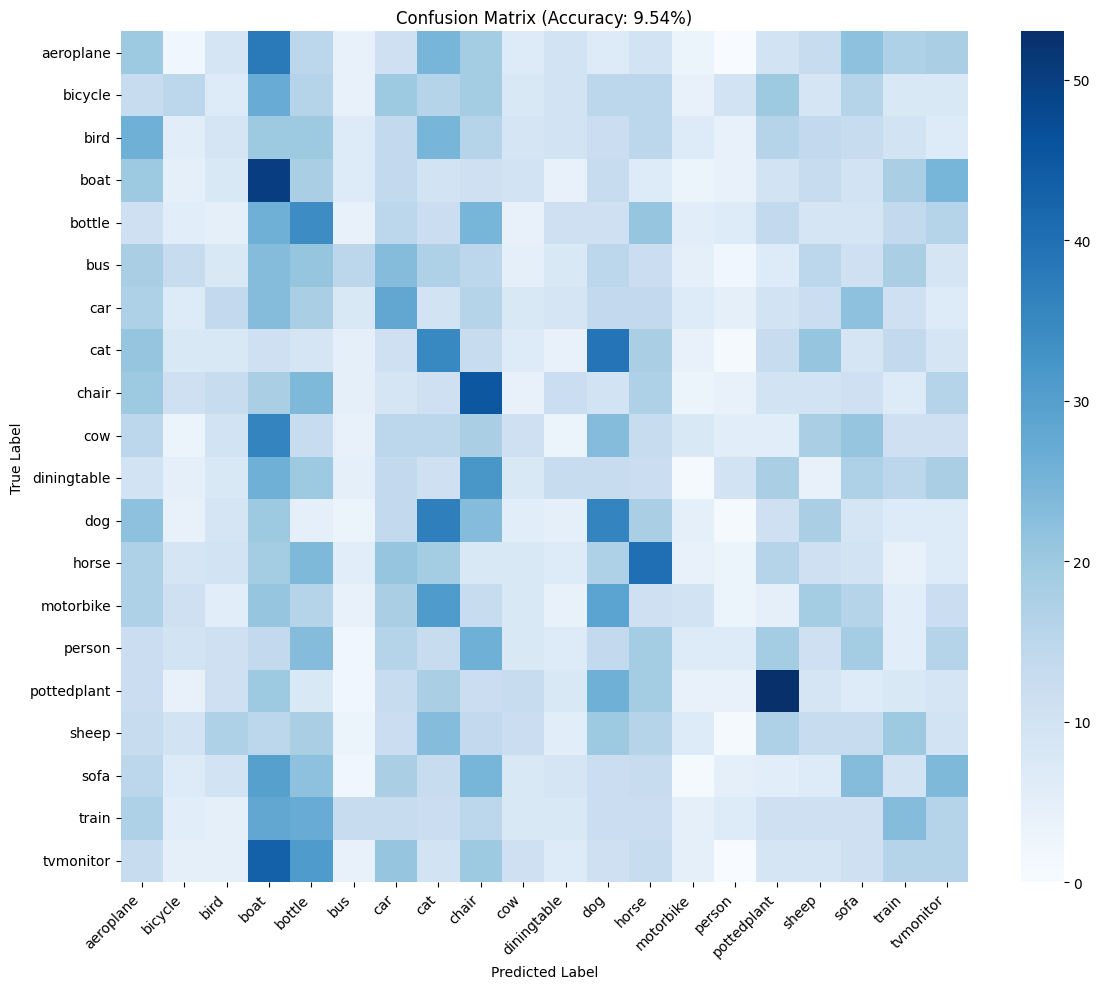

In [30]:
# ========== LOAD AND EVALUATE BEST MODEL ==========
print("\n" + "="*60)
print("LOADING BEST MODEL FOR EVALUATION")
print("="*60)

# Load best model
print("\n" + "="*60)
print("LOADING BEST MODEL")
print("="*60)

checkpoint = torch.load(f'checkpoints/best_baseline_task1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate
results = evaluate_task1(model, test_loader, device)

# Save results
results_summary = {
    'model_type': MODEL_TYPE,
    'overall_accuracy': float(results['overall_acc']),
    'chance_level': 5.0,
    'above_chance': results['overall_acc'] > 5,
    'subject_accuracies': {int(k): float(v) for k, v in results['subject_accs'].items()},
    'class_accuracies': {int(k): float(v) for k, v in results['class_accs'].items()}
}

with open(f'task1_{MODEL_TYPE}_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✓ Results saved to: task1_{MODEL_TYPE}_results.json")

In [29]:
!pwd


/jet/home/gulavani


## Task 2A: Image-Caption Retrieval with CLIP

In [33]:
print("\n" + "="*60)
print("TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP")
print("="*60)

# Load pretrained CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

print("✓ CLIP model loaded")


@torch.no_grad()
def extract_clip_embeddings(dataset, clip_model, clip_processor, clip_tokenizer, 
                            device, batch_size=32):
    """Extract CLIP embeddings for images and captions"""
    
    # Get unique images and captions
    unique_data = {}
    for item in dataset.trial_metadata:
        img_name = item['image_name']  # Changed
        if img_name not in unique_data:
            img_path = dataset._get_image_path(img_name)
            unique_data[img_name] = {
                'caption': item['caption'],
                'category_label': item['label'],  # Changed
                'img_path': img_path
            }
    
    image_names = list(unique_data.keys())
    captions = [unique_data[name]['caption'] for name in image_names]
    labels = torch.tensor([unique_data[name]['category_label'] for name in image_names])
    
    print(f"Extracting embeddings for {len(image_names)} unique images...")
    
    image_embeddings = []
    text_embeddings = []
    
    for i in tqdm(range(0, len(image_names), batch_size)):
        batch_names = image_names[i:i+batch_size]
        batch_captions = captions[i:i+batch_size]
        
        # Load images
        batch_images = []
        for name in batch_names:
            try:
                img = Image.open(unique_data[name]['img_path']).convert('RGB')
                batch_images.append(img)
            except:
                batch_images.append(Image.new('RGB', (224, 224)))
        
        # Process
        image_inputs = clip_processor(images=batch_images, return_tensors="pt", padding=True)
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
        
        text_inputs = clip_tokenizer(batch_captions, padding=True, truncation=True, 
                                    return_tensors="pt", max_length=77)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        # Get embeddings
        image_features = clip_model.get_image_features(**image_inputs)
        text_features = clip_model.get_text_features(**text_inputs)
        
        # Normalize
        image_features = F.normalize(image_features, p=2, dim=-1)
        text_features = F.normalize(text_features, p=2, dim=-1)
        
        image_embeddings.append(image_features.cpu())
        text_embeddings.append(text_features.cpu())
    
    image_embeddings = torch.cat(image_embeddings, dim=0)
    text_embeddings = torch.cat(text_embeddings, dim=0)
    
    return {
        'image_names': image_names,
        'captions': captions,
        'labels': labels,
        'image_embeddings': image_embeddings,
        'text_embeddings': text_embeddings
    }


def compute_recall_at_k(similarities, k_values=[1, 3, 5], class_aware=False, labels=None):
    """Compute Recall@K"""
    N = similarities.shape[0]
    
    # Move similarities to same device for sorting
    device = similarities.device
    top_k_indices = torch.argsort(similarities, dim=1, descending=True)
    
    # Ensure labels are on the same device if using class-aware
    if class_aware and labels is not None:
        labels = labels.to(device)
    
    results = {}
    for k in k_values:
        correct = 0
        
        for i in range(N):
            top_k = top_k_indices[i, :k]
            
            if class_aware and labels is not None:
                query_label = labels[i]
                retrieved_labels = labels[top_k]
                if (retrieved_labels == query_label).any():
                    correct += 1
            else:
                if i in top_k:
                    correct += 1
        
        results[f"Recall@{k}"] = 100.0 * correct / N
    
    return results


def compute_map(similarities, class_aware=False, labels=None):
    """Compute Mean Average Precision"""
    N = similarities.shape[0]
    device = similarities.device
    
    # Ensure everything is on CPU for numpy operations
    similarities_cpu = similarities.cpu() if similarities.is_cuda else similarities
    sorted_indices = torch.argsort(similarities_cpu, dim=1, descending=True)
    
    if labels is not None:
        labels_cpu = labels.cpu() if labels.is_cuda else labels
        labels_np = labels_cpu.numpy()
    
    average_precisions = []
    
    for i in range(N):
        sorted_idx = sorted_indices[i]
        
        if class_aware and labels is not None:
            query_label = labels_np[i]
            relevant_mask = (labels_np == query_label)
        else:
            relevant_mask = np.zeros(N, dtype=bool)
            relevant_mask[i] = True
        
        precisions = []
        num_relevant = 0
        
        for rank, idx in enumerate(sorted_idx, 1):
            if relevant_mask[idx]:
                num_relevant += 1
                precisions.append(num_relevant / rank)
        
        if precisions:
            average_precisions.append(np.mean(precisions))
        else:
            average_precisions.append(0.0)
    
    return np.mean(average_precisions)


def evaluate_task2a(test_dataset, clip_model, clip_processor, clip_tokenizer, device):
    """Full evaluation for Task 2A"""
    
    # Extract embeddings
    embeddings = extract_clip_embeddings(
        test_dataset, clip_model, clip_processor, clip_tokenizer, device)
    
    image_emb = embeddings['image_embeddings'].to(device)
    text_emb = embeddings['text_embeddings'].to(device)
    labels = embeddings['labels']  # Keep on CPU initially
    
    # Compute similarities
    similarities = torch.mm(image_emb, text_emb.t())
    
    print(f"\n{'='*60}")
    print(f"TASK 2A: IMAGE-CAPTION RETRIEVAL RESULTS")
    print(f"{'='*60}")
    
    # Instance-level Recall@K
    print("\n1. Instance-Level Recall@K:")
    instance_recall = compute_recall_at_k(similarities, k_values=[1, 3, 5])
    for k, v in instance_recall.items():
        print(f"   {k}: {v:.2f}%")
    
    # Class-aware Recall@K (labels will be moved to device inside function)
    print("\n2. Class-Aware Recall@K:")
    class_recall = compute_recall_at_k(similarities, k_values=[1, 3, 5], 
                                      class_aware=True, labels=labels)
    for k, v in class_recall.items():
        print(f"   {k}: {v:.2f}%")
    
    # MAP (will be computed on CPU inside function)
    print("\n3. Mean Average Precision:")
    instance_map = compute_map(similarities, labels=labels)
    print(f"   Instance-Level MAP: {instance_map:.4f}")
    
    class_map = compute_map(similarities, class_aware=True, labels=labels)
    print(f"   Class-Aware MAP: {class_map:.4f}")
    
    return {
        'instance_recall': instance_recall,
        'class_recall': class_recall,
        'instance_map': instance_map,
        'class_map': class_map,
        'embeddings': embeddings
    }


TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP
✓ CLIP model loaded


In [34]:
# --------------------------------------------------------------------------
# TASK 2A: IMAGE-CAPTION RETRIEVAL
# --------------------------------------------------------------------------

print("\n" + "="*60)
print("STARTING TASK 2A: IMAGE-CAPTION RETRIEVAL")
print("="*60)

# Task 2A: Evaluate CLIP on image-caption retrieval
task2a_results = evaluate_task2a(test_ds, clip_model, clip_processor, 
                                  clip_tokenizer, DEVICE)

print(f"\nTask 2A (Image-Caption) Recall@5: {task2a_results['instance_recall']['Recall@5']:.2f}%")


STARTING TASK 2A: IMAGE-CAPTION RETRIEVAL
Extracting embeddings for 4046 unique images...


  0%|          | 0/127 [00:00<?, ?it/s]


TASK 2A: IMAGE-CAPTION RETRIEVAL RESULTS

1. Instance-Level Recall@K:
   Recall@1: 27.63%
   Recall@3: 44.86%
   Recall@5: 53.51%

2. Class-Aware Recall@K:
   Recall@1: 96.69%
   Recall@3: 98.10%
   Recall@5: 98.64%

3. Mean Average Precision:
   Instance-Level MAP: 0.3994
   Class-Aware MAP: 0.8308

Task 2A (Image-Caption) Recall@5: 53.51%


## Task 2B: EEG-Caption Retrieval

### EEG-to-CLIP Projection Head

In [51]:
print("\n" + "="*60)
print("TASK 2B: EEG-CAPTION RETRIEVAL")
print("="*60)

# Load the trained EEG encoder from Task 1
print("\n[1/5] Loading trained EEG encoder from Task 1...")

eeg_encoder = EEG_ViT_1D(num_subjects=13, num_classes=20).to(DEVICE)

# Load your friend's checkpoint
checkpoint = torch.load('best_model_vit_1d.pth', map_location=DEVICE)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    eeg_encoder.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded checkpoint from epoch {checkpoint.get('epoch', '?')}")
    print(f"✓ Task 1 validation accuracy was: {checkpoint.get('val_acc', 0):.2f}%")
else:
    eeg_encoder.load_state_dict(checkpoint)
    print("✓ Loaded model weights")

# Remove the classification heads - we only need the encoder part
eeg_encoder.eval()

print("✓ EEG encoder loaded and ready")


TASK 2B: EEG-CAPTION RETRIEVAL

[1/5] Loading trained EEG encoder from Task 1...
✓ Loaded checkpoint from epoch 98
✓ Task 1 validation accuracy was: 9.50%
✓ EEG encoder loaded and ready


In [52]:
print("\n[2/5] Creating projection head for CLIP alignment...")

class EEGToClipProjection(nn.Module):
    """Projects EEG embeddings to CLIP text embedding space"""
    
    def __init__(self, eeg_dim=128, clip_dim=512, hidden_dim=256):
        super().__init__()
        
        # Small MLP projection head
        self.projection = nn.Sequential(
            nn.Linear(eeg_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, clip_dim)
        )
    
    def forward(self, eeg_embedding):
        """
        Args:
            eeg_embedding: (batch, 128) from EEG encoder's CLS token
        Returns:
            projected: (batch, 512) normalized CLIP-space embedding
        """
        projected = self.projection(eeg_embedding)
        # Normalize to unit length (CRITICAL for cosine similarity)
        projected = F.normalize(projected, p=2, dim=-1)
        return projected

projection_head = EEGToClipProjection(eeg_dim=128, clip_dim=512).to(DEVICE)

print(f"✓ Projection head created")
print(f"  Trainable parameters: {sum(p.numel() for p in projection_head.parameters() if p.requires_grad):,}")


[2/5] Creating projection head for CLIP alignment...
✓ Projection head created
  Trainable parameters: 164,608


In [53]:
print("\n[3/5] Implementing loss functions...")

class Task2BLosses:
    """Loss functions for EEG-Caption alignment"""
    
    @staticmethod
    def cosine_similarity_loss(eeg_emb, text_emb):
        """
        Knowledge Distillation: Similarity-based
        Align EEG with ground-truth caption
        """
        # Both should be normalized already
        cosine_sim = torch.sum(eeg_emb * text_emb, dim=-1)  # (batch,)
        loss = 1 - cosine_sim.mean()  # Want similarity = 1
        return loss
    
    @staticmethod
    def contrastive_loss_debiased(eeg_emb, text_emb, labels, temperature=0.07):
        """
        Debiased Contrastive Loss (InfoNCE with soft negatives)
        Down-weights same-class captions in negative set
        
        Args:
            eeg_emb: (batch, 512) normalized EEG embeddings
            text_emb: (batch, 512) normalized text embeddings  
            labels: (batch,) category labels
            temperature: scaling factor
        """
        batch_size = eeg_emb.shape[0]
        
        # Compute similarity matrix: (batch, batch)
        logits = torch.mm(eeg_emb, text_emb.t()) / temperature
        
        # Create weight matrix for negatives
        # Same class = lower weight, different class = full weight
        labels_eq = labels.unsqueeze(0) == labels.unsqueeze(1)  # (batch, batch)
        
        # Diagonal = positives (weight doesn't matter, excluded from denominator)
        # Same class = 0.3 weight, different class = 1.0 weight
        weights = torch.where(labels_eq, 
                            torch.tensor(0.3, device=DEVICE),
                            torch.tensor(1.0, device=DEVICE))
        weights = weights.fill_diagonal_(0)  # Ignore diagonal in denominator
        
        # Compute loss
        # Numerator: positive pairs (diagonal)
        positive_logits = torch.diag(logits)  # (batch,)
        
        # Denominator: weighted sum of all pairs
        exp_logits = torch.exp(logits)
        weighted_exp = exp_logits * weights
        
        # Add back the positive (diagonal) 
        denominator = weighted_exp.sum(dim=1) + torch.exp(positive_logits)
        
        loss = -torch.log(torch.exp(positive_logits) / denominator).mean()
        
        return loss
    
    @staticmethod
    def kl_divergence_loss(eeg_emb, text_emb_all, image_emb, temperature_teacher=0.07, temperature_student=0.07):
        """
        Knowledge Distillation: Logit-based
        Student (EEG) mimics Teacher (CLIP image encoder) distribution
        
        Args:
            eeg_emb: (batch, 512) student embeddings
            text_emb_all: (N_captions, 512) all caption embeddings in dataset
            image_emb: (batch, 512) teacher (CLIP image) embeddings
            temperature_teacher/student: softmax temperatures
        """
        # Teacher distribution: image -> all captions
        teacher_logits = torch.mm(image_emb, text_emb_all.t()) / temperature_teacher
        teacher_probs = F.softmax(teacher_logits, dim=-1)
        
        # Student distribution: EEG -> all captions  
        student_logits = torch.mm(eeg_emb, text_emb_all.t()) / temperature_student
        student_log_probs = F.log_softmax(student_logits, dim=-1)
        
        # KL divergence
        kl_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean')
        
        return kl_loss

print("✓ Loss functions implemented:")
print("  - Cosine similarity (KD similarity-based)")
print("  - Debiased contrastive (InfoNCE with soft negatives)")
print("  - KL divergence (KD logit-based)")


[3/5] Implementing loss functions...
✓ Loss functions implemented:
  - Cosine similarity (KD similarity-based)
  - Debiased contrastive (InfoNCE with soft negatives)
  - KL divergence (KD logit-based)


In [54]:
print("\n[4/5] Setting up evaluation function...")

@torch.no_grad()
def evaluate_eeg_caption_retrieval(eeg_encoder, projection_head, clip_model, 
                                   clip_tokenizer, dataloader, device, k=5):
    """
    Evaluate EEG-Caption retrieval
    Returns Class-Aware Recall@K
    """
    eeg_encoder.eval()
    projection_head.eval()
    clip_model.eval()
    
    all_eeg_emb = []
    all_text_emb = []
    all_labels = []
    
    for batch in tqdm(dataloader, desc=f"Evaluating Recall@{k}", leave=False):
        eeg_data = batch['eeg'].to(device)
        captions = batch['caption']
        labels = batch['label']
        subject_ids = batch['subject_id'].to(device)
        
        # Get EEG embedding (same as training)
        x = eeg_data
        
        # Dimension handling
        if x.shape[1] == 500 and x.shape[2] == 122:
            x = x.permute(0, 2, 1)
        if x.shape[2] > 500:
            x = x[:, :, :500]
        
        # Tokenize
        x = eeg_encoder.tokenizer(x)
        x = x.permute(0, 2, 1)
        
        b, seq_len, _ = x.shape
        
        # Add CLS token
        cls_tokens = eeg_encoder.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embedding
        x = x + eeg_encoder.pos_embedding[:, :seq_len + 1, :]
        
        # Transformer
        x = eeg_encoder.transformer(x)
        
        # Extract CLS token
        eeg_cls = x[:, 0, :]
        
        # Project to CLIP space
        eeg_projected = projection_head(eeg_cls)
        
        # Get text embedding
        text_inputs = clip_tokenizer(captions, padding=True, truncation=True,
                                     return_tensors="pt", max_length=77)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        text_emb = clip_model.get_text_features(**text_inputs)
        text_emb = F.normalize(text_emb, p=2, dim=-1)
        
        all_eeg_emb.append(eeg_projected.cpu())
        all_text_emb.append(text_emb.cpu())
        all_labels.append(labels)
    
    # Concatenate all batches
    eeg_emb = torch.cat(all_eeg_emb, dim=0).to(device)
    text_emb = torch.cat(all_text_emb, dim=0).to(device)
    labels = torch.cat(all_labels, dim=0).to(device)
    
    # Compute similarity matrix
    similarities = torch.mm(eeg_emb, text_emb.t())  # (N, N)
    
    # Get top-K indices for each query
    top_k_indices = torch.argsort(similarities, dim=1, descending=True)[:, :k]
    
    # Compute class-aware Recall@K
    correct = 0
    for i in range(len(labels)):
        query_label = labels[i]
        retrieved_labels = labels[top_k_indices[i]]
        if (retrieved_labels == query_label).any():
            correct += 1
    
    recall = 100.0 * correct / len(labels)
    return recall

print("✓ Evaluation function ready")
print("\n" + "="*60)
print("SETUP COMPLETE - Ready to train Task 2B!")
print("="*60)


[4/5] Setting up evaluation function...
✓ Evaluation function ready

SETUP COMPLETE - Ready to train Task 2B!


In [55]:
print("\n[5/5] Setting up training function...")

def train_task2b(eeg_encoder, projection_head, clip_model, clip_tokenizer, 
                 train_loader, val_loader,
                 strategy='frozen', num_epochs=20, lr=1e-3, 
                 loss_weights={'cosine': 1.0, 'contrastive': 1.0}):
    """
    Train EEG-Caption alignment with different CLIP fine-tuning strategies
    
    Args:
        strategy: 'frozen', 'partial_unfreeze'
        loss_weights: dict with keys 'cosine', 'contrastive'
    """
    
    print(f"\n{'='*60}")
    print(f"Training with strategy: {strategy.upper()}")
    print(f"Loss weights: {loss_weights}")
    print(f"{'='*60}\n")
    
    # Configure CLIP based on strategy
    if strategy == 'frozen':
        print("Strategy: CLIP fully frozen")
        for param in clip_model.parameters():
            param.requires_grad = False
        trainable_params = list(projection_head.parameters())
        
    elif strategy == 'partial_unfreeze':
        print("Strategy: Unfreezing last 2 CLIP layers + text projection")
        # Freeze all first
        for param in clip_model.parameters():
            param.requires_grad = False
        
        # Unfreeze last 2 transformer layers
        for layer in clip_model.text_model.encoder.layers[-2:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # Unfreeze text projection
        if hasattr(clip_model, 'text_projection'):
            for param in clip_model.text_projection.parameters():
                param.requires_grad = True
        
        trainable_params = list(projection_head.parameters())
        for layer in clip_model.text_model.encoder.layers[-2:]:
            trainable_params.extend(list(layer.parameters()))
        if hasattr(clip_model, 'text_projection'):
            trainable_params.extend(list(clip_model.text_projection.parameters()))
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")
    
    # Count trainable parameters
    total_trainable = sum(p.numel() for p in trainable_params if p.requires_grad)
    print(f"\nTrainable parameters: {total_trainable:,}")
    
    # Optimizer
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
    
    # Loss computer
    loss_computer = Task2BLosses()
    
    # Training loop
    best_val_recall = 0.0
    
    for epoch in range(num_epochs):
        # ===== TRAINING =====
        eeg_encoder.eval()  # Keep EEG encoder frozen
        projection_head.train()
        if strategy != 'frozen':
            clip_model.train()
        else:
            clip_model.eval()
        
        epoch_losses = {'total': 0, 'cosine': 0, 'contrastive': 0}
        num_batches = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            eeg_data = batch['eeg'].to(DEVICE)
            captions = batch['caption']
            labels = batch['label'].to(DEVICE)
            subject_ids = batch['subject_id'].to(DEVICE)
            
            optimizer.zero_grad()
            
            # Get EEG embedding using model's forward pass
            # We need to extract intermediate representation before classification heads
            with torch.no_grad():
                # Forward through tokenizer and transformer
                x = eeg_data
                
                # Dimension handling (from model's forward)
                if x.shape[1] == 500 and x.shape[2] == 122:
                    x = x.permute(0, 2, 1)
                if x.shape[2] > 500:
                    x = x[:, :, :500]
                
                # Tokenize
                x = eeg_encoder.tokenizer(x)
                x = x.permute(0, 2, 1)
                
                b, seq_len, _ = x.shape
                
                # Add CLS token
                cls_tokens = eeg_encoder.cls_token.expand(b, -1, -1)
                x = torch.cat((cls_tokens, x), dim=1)
                
                # Add positional embedding
                x = x + eeg_encoder.pos_embedding[:, :seq_len + 1, :]
                
                # Transformer
                x = eeg_encoder.transformer(x)
                
                # Extract CLS token
                eeg_cls = x[:, 0, :]  # (batch, 128)
            
            # Project to CLIP space
            eeg_projected = projection_head(eeg_cls)  # (batch, 512), normalized
            
            # Get text embeddings from CLIP
            text_inputs = clip_tokenizer(captions, padding=True, truncation=True,
                                        return_tensors="pt", max_length=77)
            text_inputs = {k: v.to(DEVICE) for k, v in text_inputs.items()}
            
            text_emb = clip_model.get_text_features(**text_inputs)
            text_emb = F.normalize(text_emb, p=2, dim=-1)
            
            # Compute losses
            total_loss = 0
            
            if loss_weights.get('cosine', 0) > 0:
                loss_cos = loss_computer.cosine_similarity_loss(eeg_projected, text_emb)
                total_loss += loss_weights['cosine'] * loss_cos
                epoch_losses['cosine'] += loss_cos.item()
            
            if loss_weights.get('contrastive', 0) > 0:
                loss_contrast = loss_computer.contrastive_loss_debiased(
                    eeg_projected, text_emb, labels)
                total_loss += loss_weights['contrastive'] * loss_contrast
                epoch_losses['contrastive'] += loss_contrast.item()
            
            epoch_losses['total'] += total_loss.item()
            num_batches += 1
            
            total_loss.backward()
            optimizer.step()
        
        # Print epoch stats
        avg_total = epoch_losses['total'] / num_batches
        avg_cos = epoch_losses['cosine'] / num_batches
        avg_contrast = epoch_losses['contrastive'] / num_batches
        
        print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {avg_total:.4f} " +
              f"(Cosine: {avg_cos:.4f}, Contrastive: {avg_contrast:.4f})")
        
        # ===== VALIDATION =====
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:  # Validate every 5 epochs and last epoch
            val_recall = evaluate_eeg_caption_retrieval(
                eeg_encoder, projection_head, clip_model, clip_tokenizer, 
                val_loader, DEVICE, k=5)
            
            print(f"  → Val Recall@5: {val_recall:.2f}%")
            
            if val_recall > best_val_recall:
                best_val_recall = val_recall
                save_path = f'task2b_best_{strategy}.pth'
                torch.save({
                    'projection_head': projection_head.state_dict(),
                    'epoch': epoch + 1,
                    'strategy': strategy,
                    'val_recall': val_recall,
                    'loss_weights': loss_weights
                }, save_path)
                print(f"  ✓ Best model saved to {save_path}!")
    
    print(f"\n{'='*60}")
    print(f"Training complete!")
    print(f"Best Val Recall@5: {best_val_recall:.2f}%")
    print(f"{'='*60}\n")
    
    return projection_head, best_val_recall

print("✓ Training function ready")


[5/5] Setting up training function...
✓ Training function ready


In [ ]:
print("\n" + "="*60)
print("TRAINING TASK 2B - STRATEGY: FROZEN CLIP")
print("="*60)

# Create fresh projection head
projection_head_frozen = EEGToClipProjection(eeg_dim=128, clip_dim=512).to(DEVICE)

# Train with frozen CLIP (baseline)
trained_projection, best_recall = train_task2b(
    eeg_encoder=eeg_encoder,
    projection_head=projection_head_frozen,
    clip_model=clip_model,
    clip_tokenizer=clip_tokenizer,
    train_loader=train_loader,
    val_loader=val_loader,
    strategy='frozen',
    num_epochs=20,
    lr=1e-3,
    loss_weights={'cosine': 0.5, 'contrastive': 0.5}
)

print(f"\n✓ Training completed with best validation Recall@5: {best_recall:.2f}%")


TRAINING TASK 2B - STRATEGY: FROZEN CLIP

Training with strategy: FROZEN
Loss weights: {'cosine': 0.5, 'contrastive': 0.5}

Strategy: CLIP fully frozen

Trainable parameters: 164,608


Epoch 1/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 1/20 - Total Loss: 1.9141 (Cosine: 0.4146, Contrastive: 3.4136)


Epoch 2/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 2/20 - Total Loss: 1.8699 (Cosine: 0.3669, Contrastive: 3.3729)


Epoch 3/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 3/20 - Total Loss: 1.8612 (Cosine: 0.3663, Contrastive: 3.3560)


Epoch 4/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 4/20 - Total Loss: 1.8544 (Cosine: 0.3674, Contrastive: 3.3414)


Epoch 5/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 5/20 - Total Loss: 1.8480 (Cosine: 0.3682, Contrastive: 3.3279)


Evaluating Recall@5:   0%|          | 0/163 [00:00<?, ?it/s]

  → Val Recall@5: 14.12%
  ✓ Best model saved to task2b_best_frozen.pth!


Epoch 6/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 6/20 - Total Loss: 1.8432 (Cosine: 0.3707, Contrastive: 3.3156)


Epoch 7/20:   0%|          | 0/488 [00:00<?, ?it/s]

Epoch 7/20 - Total Loss: 1.8370 (Cosine: 0.3734, Contrastive: 3.3005)


Epoch 8/20:   0%|          | 0/488 [00:00<?, ?it/s]